In [434]:
%load_ext autoreload
%autoreload 2
import sys
if ".." not in sys.path:
    sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import asdict

from products.vanilla_option import VanillaOption
from models.model_params import LewisParams, MCParams, HestonParams
from models.heston import Heston
from utility.utility import from_delta_call_to_strike

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Model definition

In [435]:
model_params = HestonParams(V0=0.05, theta=0.06, lam=2, nu=0.4, rho=-0.3)

model = Heston(**asdict(model_params))
model.compile()

### Price and variance trajectories

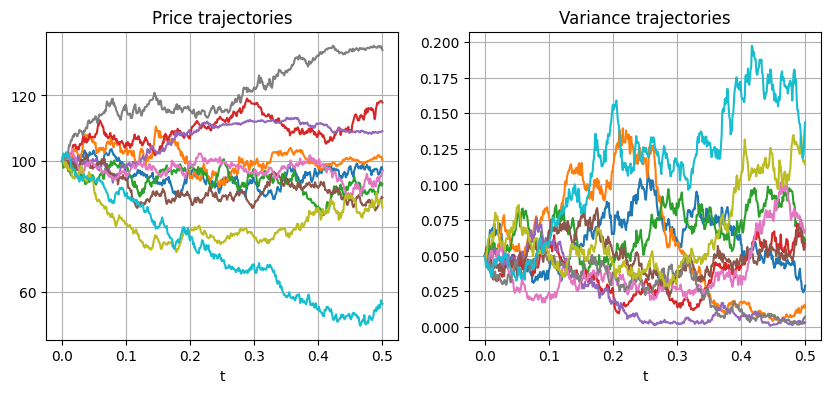

In [439]:
size = 10
N_grid = 500

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=41)

prices, V = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_variance=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for price, vol in zip(prices, V):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)

ax[0].set_xlabel("t")
ax[1].set_xlabel("t")
ax[0].set_title("Price trajectories")
ax[1].set_title("Variance trajectories")
ax[0].grid()
ax[1].grid()

### Implied volatility smile

In [451]:
F0 = 100
T = 0.5
K = from_delta_call_to_strike(deltas = 1 - np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.2, ttm=T)
k = np.log(K / F0)

option_call = VanillaOption(T=T, K=K, flag="call")

#### Via Monte Carlo

In [456]:
%%time

size = 10**5

smile_mc_call, mc_call_lower, mc_call_upper = option_call.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=size, batch_size=100_000, return_accuracy=True, timestep=0.001, rng=rng)
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.47s/it]

CPU times: total: 7.95 s
Wall time: 8.48 s


#### Via Fourier

In [452]:
%%time
smile_cf = option_call.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True, 
                                 pricing_params=LewisParams(cf_timestep=0.001, N_points=25))

CPU times: total: 15.6 ms
Wall time: 7.58 ms


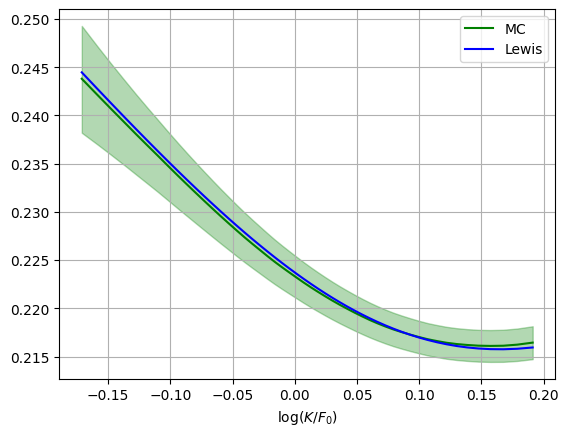

In [457]:
fig, ax = plt.subplots()
ax.plot(np.log(K / F0), smile_mc_call, "g", label="MC")
ax.fill_between(np.log(K / F0), mc_call_lower, mc_call_upper, color="g", alpha=0.3)

ax.plot(k, smile_cf, "b", label="Lewis")

ax.grid()
ax.set_xlabel(r"$\log(K / F_0)$")
ax.legend()
plt.show()

### ATM skew

Text(0.5, 1.0, 'ATM skew')

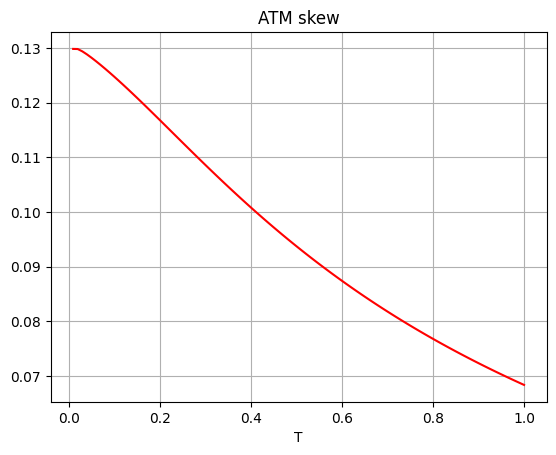

In [458]:
bump = 0.05
K_skew = np.array([1 - bump, 1 + bump]) * F0
k_skew = np.log(K_skew / F0)
T_skew = np.linspace(0.01, 1, 100)

option_call_skew = VanillaOption(T=T_skew, K=K_skew, flag="call")

smile_skew = option_call_skew.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True, 
                                        pricing_params=LewisParams(cf_timestep=0.0001, N_points=50))

atm_skew = -(np.diff(smile_skew, axis=1) / np.diff(k_skew)).squeeze()

fig, ax = plt.subplots()

ax.plot(T_skew, atm_skew, color='r')
ax.grid()
ax.set_xlabel("T")
ax.set_title("ATM skew")